In [1]:
!{sys.executable} -m pip install pandas matplotlib seaborn ipywidgets

zsh:1: parse error near `-m'


Importer les bibliothèques 


In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


Carte des 10 villes ayant la plus grande valeur foncière moyenne pour chaque département


Ce code charge les données foncières depuis un fichier CSV, filtre celles de l'année 2024, calcule les statistiques (valeur foncière moyenne, totale, nombre de transactions) par ville et département, puis sélectionne les 10 villes les plus attractives par département. Une carte interactive centrée sur la France est générée avec des marqueurs pour ces villes, enregistrée sous forme de fichier HTML pour visualisation.

In [52]:
import pandas as pd
import folium

# Chemin du fichier combiné
file = '/Users/hafsaredouane/Downloads/combined_land_data_all.csv'

# Chargement des données
all_data = pd.read_csv(file, low_memory=False)

# Vérifiez si la colonne Département existe ou renommez-la
if 'Département' not in all_data.columns and 'code_departement' in all_data.columns:
    all_data.rename(columns={'code_departement': 'Département'}, inplace=True)

# Nettoyer les noms de colonnes
all_data.columns = all_data.columns.str.strip()

# Vérifiez si les colonnes nécessaires existent
if 'nom_commune' not in all_data.columns or 'date_mutation' not in all_data.columns:
    raise KeyError("Les colonnes 'nom_commune' ou 'date_mutation' sont absentes des données.")

# Convertir la colonne 'date_mutation' en format datetime
all_data['date_mutation'] = pd.to_datetime(all_data['date_mutation'], errors='coerce')

# Filtrer les données pour l'année 2024
data_2024 = all_data[all_data['date_mutation'].dt.year == 2024]

# Supprimer les lignes avec des valeurs manquantes
data_2024 = data_2024.dropna(subset=['latitude', 'longitude', 'valeur_fonciere', 'nom_commune', 'Département'])

# Calculer les statistiques par ville et département
valeur_fonciere_par_ville = data_2024.groupby(['Département', 'nom_commune']).agg({
    'valeur_fonciere': ['mean', 'sum', 'count'],
    'latitude': 'first',
    'longitude': 'first'
}).reset_index()

# Renommer les colonnes pour une meilleure clarté
valeur_fonciere_par_ville.columns = ['Département', 'nom_commune', 'valeur_fonciere_moyenne', 
                                     'valeur_fonciere_totale', 'nombre_transactions', 'latitude', 'longitude']

# Sélectionner les 10 villes ayant la plus grande valeur foncière moyenne pour chaque département
top_10_villes_par_departement = valeur_fonciere_par_ville.groupby('Département').apply(
    lambda x: x.nlargest(10, 'valeur_fonciere_moyenne')
).reset_index(drop=True)

# Créer une carte centrée sur la France
carte = folium.Map(location=[46.603354, 1.888334], zoom_start=6)

# Ajouter des marqueurs pour chaque ville
for _, row in top_10_villes_par_departement.iterrows():
    popup = (
        f"Ville : {row['nom_commune']}<br>"
        f"Département : {row['Département']}<br>"
        f"Valeur foncière moyenne : {row['valeur_fonciere_moyenne']:.2f} €<br>"
        f"Valeur foncière totale : {row['valeur_fonciere_totale']:.2f} €<br>"
        f"Nombre de transactions : {row['nombre_transactions']}"
    )
    folium.Marker(
        location=[row['latitude'], row['longitude']],
        popup=popup,
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(carte)

# Sauvegarder la carte dans un fichier HTML
output_file = '/Users/hafsaredouane/Downloads/top_10_villes_par_departement_2024.html'
carte.save(output_file)

print(f"Carte des 10 villes les plus attractives par département pour 2024 générée : {output_file}")


/var/folders/db/cf1p_xl112gds45yp5nyfppw0000gn/T/ipykernel_25817/4226429112.py:42: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Carte des 10 villes les plus attractives par département pour 2024 générée : /Users/hafsaredouane/Downloads/top_10_villes_par_departement_2024.html


Comparaison du prix au mètre carré entre le 92 et le 93 

Ce code charge les données de plusieurs fichiers CSV représentant des transactions immobilières, les combine dans un DataFrame unique, calcule les prix au m², et filtre les années 2022, 2023 et 2024. Une visualisation interactive est créée avec **Plotly**, permettant de comparer les prix au m² par commune en fonction du département et de l'année sélectionnés, grâce à un menu déroulant et un curseur.

In [12]:
import pandas as pd
import plotly.graph_objects as go


dtype_dict = {
    'code_departement': 'str',
    'valeur_fonciere': 'float32',
    'surface_reelle_bati': 'float32',
    'longitude': 'float64',
    'latitude': 'float64',
    'nom_commune': 'category',
    'type_local': 'category',
    'date_mutation': 'str'
}


files = {
    '77': '77.csv',
    '78': '78.csv',
    '91': '91.csv',
    '92': '92.csv',
    '93': '93.csv',
    '94': '94.csv',
    '95': '95.csv'
}

dfs = []
for code, file in files.items():
    df = pd.read_csv(file, dtype=dtype_dict, parse_dates=['date_mutation'], low_memory=False)
    df['code_departement'] = code  # Ajouter le code département
    dfs.append(df)

# Combinaison des données
df = pd.concat(dfs, ignore_index=True)

# Prétraitement des données
df['date_mutation'] = pd.to_datetime(df['date_mutation'], errors='coerce')
df['année'] = df['date_mutation'].dt.year
df = df.dropna(subset=['valeur_fonciere', 'surface_reelle_bati', 'nom_commune', 'code_departement', 'année'])
df['prix_m2'] = df['valeur_fonciere'] / df['surface_reelle_bati']

# Filtrer les données pour les années 2022, 2023 et 2024
df = df[df['année'].isin([2022, 2023, 2024])]

# Départements et années uniques
departements = sorted(df['code_departement'].unique())
annees = sorted(df['année'].unique())

# Création de la figure interactive
fig = go.Figure()

# Ajout des traces pour chaque département et chaque année
for departement in departements:
    for annee in annees:
        data_filtered = df[(df['code_departement'] == departement) & (df['année'] == annee)]
        prix_par_commune = data_filtered.groupby('nom_commune')['prix_m2'].median().reset_index()

        fig.add_trace(
            go.Bar(
                x=prix_par_commune['nom_commune'],
                y=prix_par_commune['prix_m2'],
                name=f"{departement} - {annee}",
                visible=False
            )
        )

# Rendre les premières traces visibles par défaut
for i in range(len(departements)):
    for j in range(len(annees)):
        index = i * len(annees) + j
        fig.data[index].visible = (i == 0 and j == 0)

# Création des boutons pour les départements
buttons_departements = [
    dict(
        label=f"Département {departement}",
        method="update",
        args=[
            {"visible": [k // len(annees) == i for k in range(len(fig.data))]},
            {"title": f"Prix par commune - Département {departement}"}
        ]
    )
    for i, departement in enumerate(departements)
]

# Création des curseurs pour les années
sliders = [
    dict(
        active=0,
        currentvalue={"prefix": "Année: ", "font": {"size": 16}},
        steps=[
            dict(
                label=str(annee),
                method="update",
                args=[
                    {"visible": [(k % len(annees)) == j for k in range(len(fig.data))]},
                    {"title": f"Prix par commune - Année {annee}"}
                ]
            )
            for j, annee in enumerate(annees)
        ]
    )
]

# Mise à jour de la disposition
fig.update_layout(
    title="Prix moyen par commune",
    xaxis_title="Commune",
    yaxis_title="Prix moyen par mètre carré (€)",
    updatemenus=[
        dict(
            buttons=buttons_departements,
            direction="down",
            showactive=True,
            x=0.1,
            xanchor="left",
            y=1.15,
            yanchor="top"
        )
    ],
    sliders=sliders
)

# Affichage de la figure
fig.show()


Répartition des ventes par mois pour une ville dans le 92

Ce code charge les données d'un fichier CSV pour les transactions immobilières du département 92, filtre les données pour les communes correspondant au code postal "92", puis les prépare en extrayant les dates et en comptant les transactions par mois. Une série de graphiques circulaires (camemberts) est générée pour visualiser la répartition des ventes par mois pour chaque commune, avec un menu interactif permettant de sélectionner la commune à afficher.

In [23]:
import pandas as pd
import plotly.express as px

# Charger les données
df = pd.read_csv('92.csv')  


df = df[df['code_postal'].astype(str).str.startswith('92')]


# Conversion de la colonne 'date_mutation' en format datetime
df['date_mutation'] = pd.to_datetime(df['date_mutation'], format='%Y-%m-%d', errors='coerce')

# Supprimer les lignes avec des dates invalides
df = df[df['date_mutation'].notna()]

# Extraire l'année et le mois des dates
df['month'] = df['date_mutation'].dt.month

# Définir les labels des mois
month_labels = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']

# Filtrer les ventes par ville et créer des camemberts interactifs pour chaque ville
def create_pie_chart_for_city(ville):
    df_filtered = df[df['nom_commune'] == ville]
    sales_per_month = df_filtered['month'].value_counts().sort_index()

    fig = px.pie(
        values=sales_per_month,
        names=[month_labels[i-1] for i in sales_per_month.index],
        title=f"Répartition des ventes par mois pour {ville}",
        hole=0.4  # Optionnel, pour créer un "donut" plutôt qu'un camembert plein
    )
    return fig

# Créer une figure avec un menu déroulant pour sélectionner la ville
villes = df['nom_commune'].unique()
figures = {ville: create_pie_chart_for_city(ville) for ville in villes}

# Menu interactif
updatemenus = [
    {
        'buttons': [
            {
                'method': 'update',
                'label': ville,
                'args': [{'visible': [v == ville for v in villes]}]  # Afficher uniquement la ville sélectionnée
            }
            for ville in villes
        ],
        'direction': 'down',
        'showactive': True
    }
]

# Créer la figure globale et initialiser l'affichage avec toutes les villes invisibles sauf la première
fig = figures[villes[0]]
for i, ville in enumerate(villes):
    if i == 0:
        continue  # Ne pas ajouter la première, elle est déjà affichée
    fig.add_trace(figures[ville].data[0])

# Appliquer le menu
fig.update_layout(updatemenus=updatemenus)

# Afficher la figure interactive
fig.show()


Nombre d'achats au cours des années en iDF 

Ce code charge les données immobilières d'un fichier CSV combiné, extrait l'année des dates de mutation, filtre pour les années 2022, 2023 et 2024, et compte le nombre total d'achats par année. Une visualisation est ensuite créée sous forme de graphique en barres avec Matplotlib, montrant la distribution des transactions immobilières au fil des années sélectionnées.

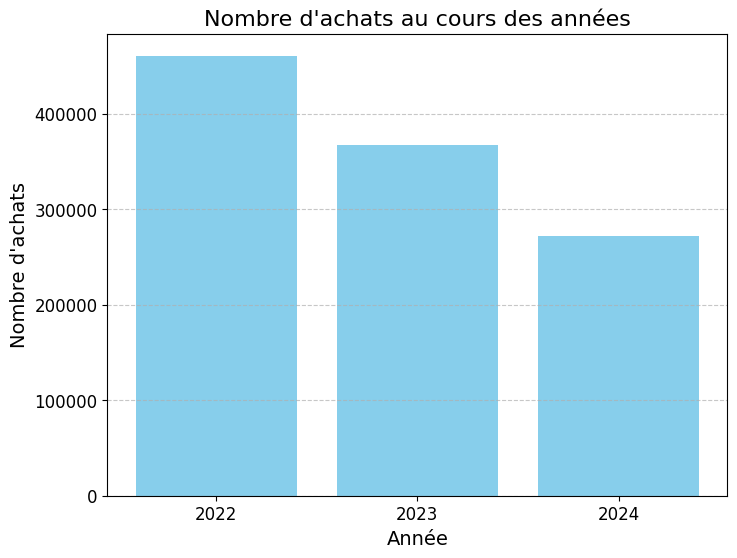

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/hafsaredouane/Downloads/combined_land_data_all.csv'


dataframes = []
for file in files:
    df = pd.read_csv(file, parse_dates=['date_mutation'], low_memory=False)
    dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)


combined_df['année'] = combined_df['date_mutation'].dt.year


filtered_df = combined_df[combined_df['année'].isin([2022, 2023, 2024])]


purchases_per_year = filtered_df.groupby('année').size()


plt.figure(figsize=(8, 6))
plt.bar(purchases_per_year.index, purchases_per_year.values, color='skyblue')
plt.title("Nombre d'achats au cours des années", fontsize=16)
plt.xlabel("Année", fontsize=14)
plt.ylabel("Nombre d'achats", fontsize=14)
plt.xticks(purchases_per_year.index, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


Évolution des achats au cours des années par département


Ce code charge un fichier combiné contenant les transactions immobilières pour différents départements, extrait les années des dates de mutation, et filtre les données pour les années 2022, 2023 et 2024. Il regroupe ensuite les transactions par département et par année pour compter le nombre d'achats. Enfin, il visualise l'évolution des transactions au cours des années sous forme de courbes, où chaque courbe représente un département distinct.

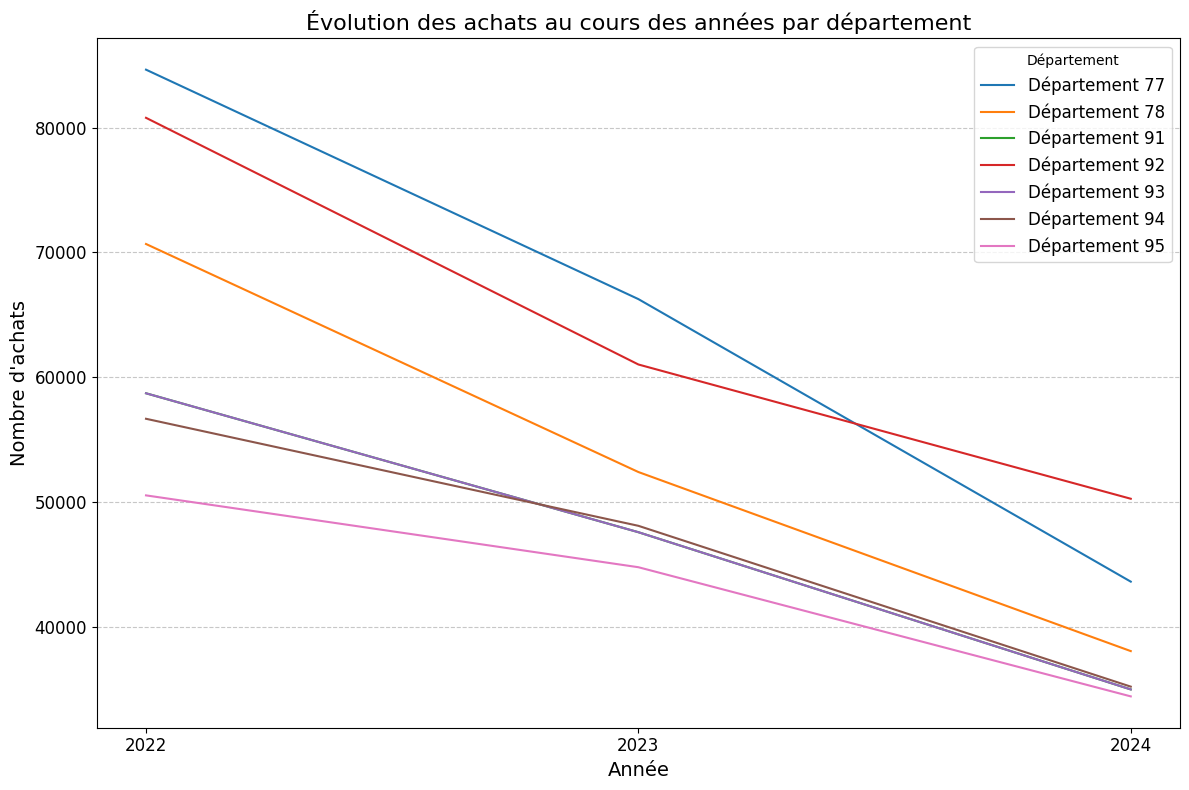

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = '/Users/hafsaredouane/Downloads/combined_land_data_all.csv'


dataframes = [] 
for dept, file in files.items():
    # Charger les données pour chaque département
    df = pd.read_csv(file, parse_dates=['date_mutation'], low_memory=False)
    df['code_departement'] = dept  
    dataframes.append(df)  

# Combiner tous les DataFrames en un seul
combined_df = pd.concat(dataframes, ignore_index=True)


combined_df['année'] = combined_df['date_mutation'].dt.year


filtered_df = combined_df[combined_df['année'].isin([2022, 2023, 2024])]

# Grouper les données par département et par année, et compter les achats
purchases_by_dept_year = filtered_df.groupby(['code_departement', 'année']).size().unstack(fill_value=0)

# Visualisation des données sous forme de courbes
plt.figure(figsize=(12, 8))

# Itérer sur chaque département et tracer une courbe
for dept in purchases_by_dept_year.index:
    plt.plot(purchases_by_dept_year.columns, purchases_by_dept_year.loc[dept], label=f"Département {dept}")

# Ajouter un titre, des étiquettes et une légende
plt.title("Évolution des achats au cours des années par département", fontsize=16)
plt.xlabel("Année", fontsize=14)
plt.ylabel("Nombre d'achats", fontsize=14)
plt.xticks(purchases_by_dept_year.columns, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Département", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  
plt.tight_layout()  
plt.show()




Analyse des Données Immobilières : Évolution des Prix, Répartition des Biens et Comparaison Départementale (2022-2024)

Ce code charge des données immobilières de plusieurs fichiers, calcule les prix au m², et analyse les données pour les années 2022 à 2024. Il génère des visualisations pour l'évolution des prix au m² par département, la répartition des types de biens immobiliers, et les départements avec les prix moyens les plus élevés.

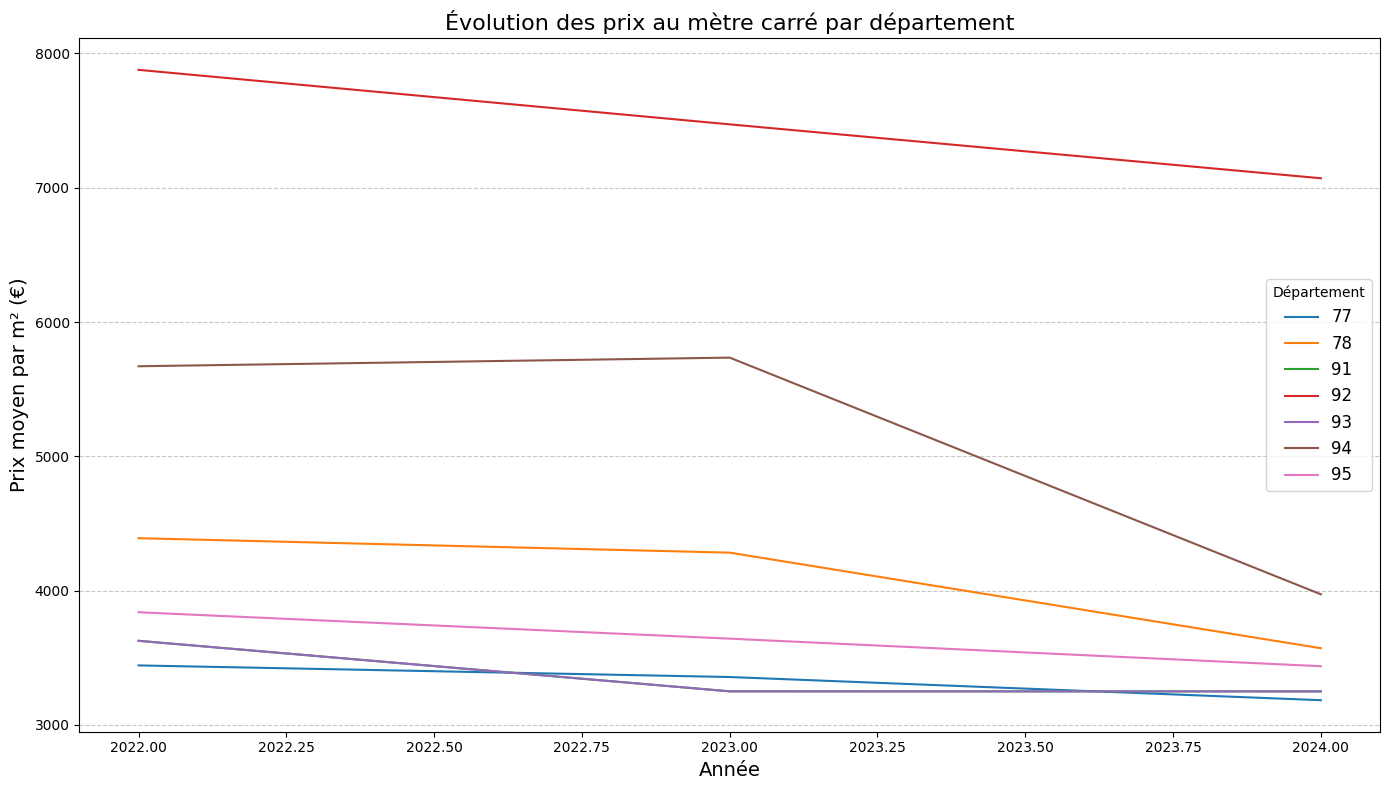

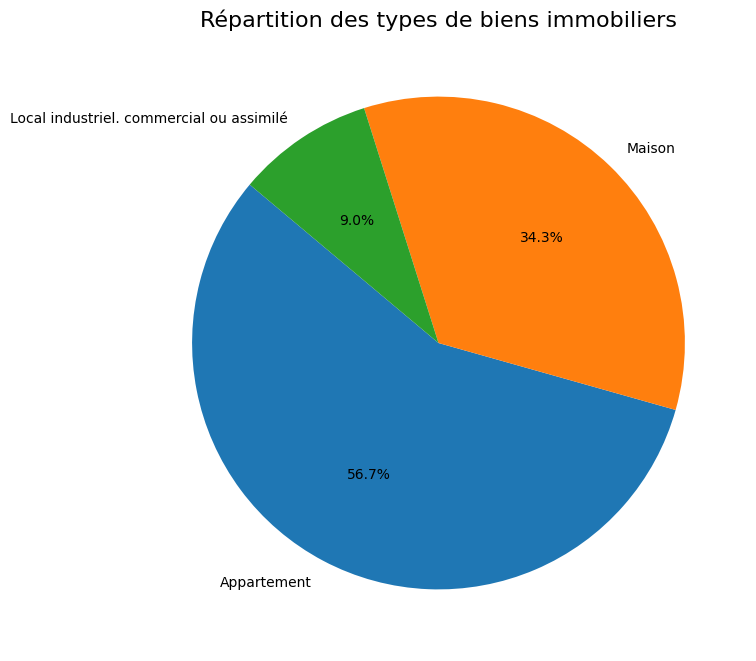

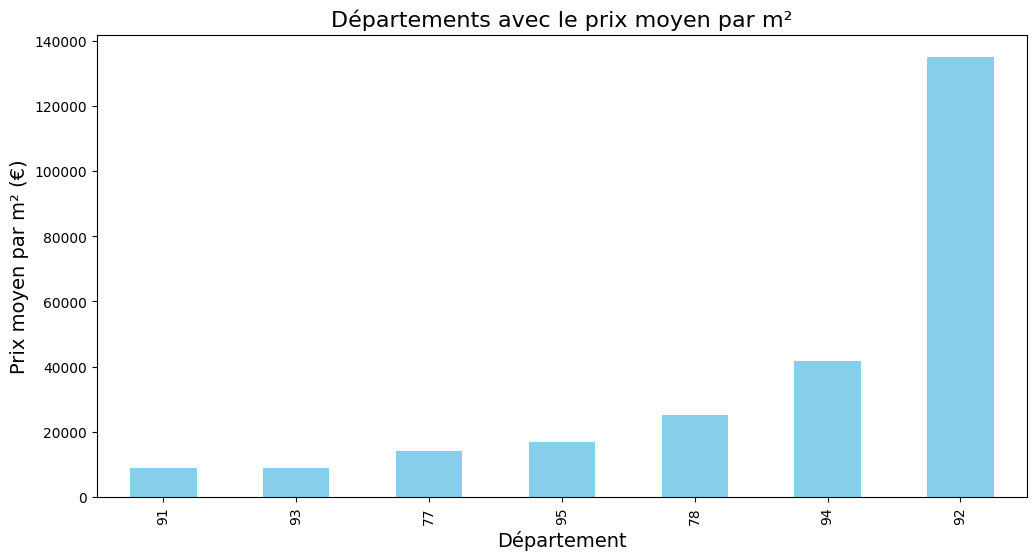

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '/Users/hafsaredouane/Downloads/combined_land_data_all.csv'


dataframes = []
for dept, file in files.items():
    df = pd.read_csv(file, parse_dates=['date_mutation'], low_memory=False)
    df['code_departement'] = dept  # Add department code
    dataframes.append(df)


combined_df = pd.concat(dataframes, ignore_index=True)


combined_df['année'] = combined_df['date_mutation'].dt.year
combined_df['month'] = combined_df['date_mutation'].dt.month
combined_df = combined_df.dropna(subset=['valeur_fonciere', 'surface_reelle_bati', 'type_local', 'code_departement'])
combined_df['prix_m2'] = combined_df['valeur_fonciere'] / combined_df['surface_reelle_bati']

filtered_df = combined_df[combined_df['année'].isin([2022, 2023, 2024])]

# 1. Evolution des prix par année
price_trends = filtered_df.groupby(['année', 'code_departement'])['prix_m2'].median().unstack()

plt.figure(figsize=(14, 8))
price_trends.plot(ax=plt.gca())
plt.title("Évolution des prix au mètre carré par département", fontsize=16)
plt.xlabel("Année", fontsize=14)
plt.ylabel("Prix moyen par m² (€)", fontsize=14)
plt.legend(title="Département", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 2. Répartition des types de biens
property_counts = filtered_df['type_local'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(property_counts, labels=property_counts.index, autopct='%1.1f%%', startangle=140)
plt.title("Répartition des types de biens immobiliers", fontsize=16)
plt.show()


# 4. départements avec prix moyen 
dept_avg_prices = filtered_df.groupby('code_departement')['prix_m2'].mean().sort_values()

plt.figure(figsize=(12, 6))
dept_avg_prices.head(10).plot(kind='bar', color='skyblue')
plt.title("Départements avec le prix moyen par m²", fontsize=16)
plt.xlabel("Département", fontsize=14)
plt.ylabel("Prix moyen par m² (€)", fontsize=14)
plt.show()




Visualisation Interactive des Prix Immobiliers : Analyse par Département et Année

Ce code charge les données immobilières à partir d'un fichier combiné, calcule la surface totale et le prix au m², puis agrège les données par département, année, et code postal pour analyser les prix moyens. Une interface interactive est créée avec ipywidgets, permettant de sélectionner un département et une année pour afficher une carte interactive avec les prix moyens au m² par code postal, visualisée à l'aide de Plotly.

In [40]:
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display, clear_output

# Chemin du fichier combiné
file_path = '/Users/hafsaredouane/Downloads/combined_land_data_all.csv'


df = pd.read_csv(file_path, dtype={
    'id_mutation': 'str',
    'valeur_fonciere': 'float32',
    'code_postal': 'float32',
    'surface_reelle_bati': 'float32',
    'lot1_surface_carrez': 'float32',
    'lot2_surface_carrez': 'float32',
    'lot3_surface_carrez': 'float32',
    'lot4_surface_carrez': 'float32',
    'lot5_surface_carrez': 'float32',
    'longitude': 'float64',
    'latitude': 'float64',
    'nom_commune': 'category', 
    'nature_mutation': 'category',
    'type_local': 'category',
    'code_departement': 'str'
}, parse_dates=['date_mutation'], low_memory=False)

# Calculer la surface totale
df['surface_totale'] = df[['surface_reelle_bati', 'lot1_surface_carrez', 'lot2_surface_carrez', 
                           'lot3_surface_carrez', 'lot4_surface_carrez', 'lot5_surface_carrez']].sum(axis=1, skipna=True)

# Calculer le prix au m²
df['prix_m2'] = df['valeur_fonciere'] / df['surface_totale']
df = df[df['prix_m2'].notna() & (df['surface_totale'] > 0)]

# Extraire l'année
df['annee'] = df['date_mutation'].dt.year

# Calculer la moyenne des prix au m² par code postal, année, et département
prix_m2_par_code_postal = df.groupby(['code_departement', 'annee', 'code_postal'], observed=True).agg(
    prix_m2_moyen=('prix_m2', 'mean'),
    nombre_logements=('prix_m2', 'size'),
    latitude=('latitude', 'first'),
    longitude=('longitude', 'first')
).reset_index()

# Vérifier les départements et années disponibles
all_departments = sorted(prix_m2_par_code_postal['code_departement'].unique())
all_years = sorted(prix_m2_par_code_postal['annee'].unique())

# Widgets pour sélectionner le département et l'année
departement_dropdown = widgets.Dropdown(
    options=all_departments,
    description='Département:',
    value=all_departments[0]
)

annee_dropdown = widgets.Dropdown(
    options=all_years,
    description='Année:',
    value=all_years[0]
)

# Output widget pour afficher la carte
output = widgets.Output()

# Fonction pour afficher la carte interactive
def update_map(department, annee):
    with output:
        clear_output(wait=True)  
        
        df_filtered = prix_m2_par_code_postal[
            (prix_m2_par_code_postal['code_departement'] == department) & 
            (prix_m2_par_code_postal['annee'] == annee)
        ]
        
        # Créer la carte
        fig = px.scatter_mapbox(
            df_filtered,
            lat="latitude",
            lon="longitude",
            color="prix_m2_moyen",
            color_continuous_scale="Reds",
            size="prix_m2_moyen",
            size_max=30,
            zoom=10,
            range_color=(df_filtered['prix_m2_moyen'].min(), df_filtered['prix_m2_moyen'].max()),
            center={"lat": 48.8566, "lon": 2.3522},  # Centre sur la région Île-de-France
            title=f"Prix moyen au m² par code postal dans le département {department} en {annee}"
        )
        
        fig.update_layout(mapbox_style="carto-positron", margin={"r":0,"t":0,"l":0,"b":0})
        fig.show()


def on_change(change):
    update_map(departement_dropdown.value, annee_dropdown.value)

departement_dropdown.observe(on_change, names='value')
annee_dropdown.observe(on_change, names='value')

# Afficher les widgets et la carte initiale
display(widgets.VBox([departement_dropdown, annee_dropdown, output]))

# Initialiser la première carte
update_map(departement_dropdown.value, annee_dropdown.value)
